In [29]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion, make_pipeline

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn import under_sampling
from imblearn import over_sampling

import seaborn as sns
import matplotlib.pyplot as plt

import streamlit as st
import scipy.stats

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv') 

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

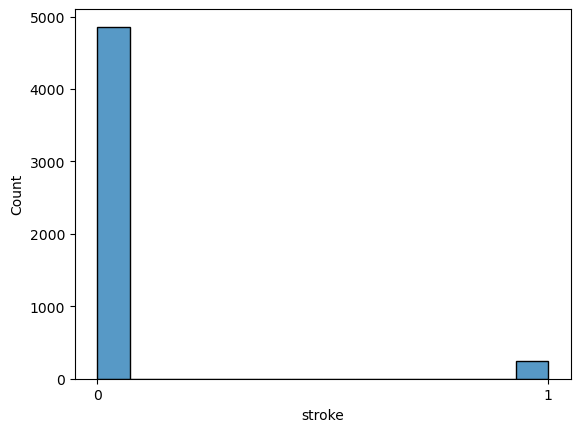

In [6]:
#check class imbalance
plot=sns.histplot(data=df.stroke)

plot.set(xticks=np.arange(0,1.1,1))

plt.savefig("hist.png",
            bbox_inches="tight",
           transparent=True); #avoid cutting off labels
                         

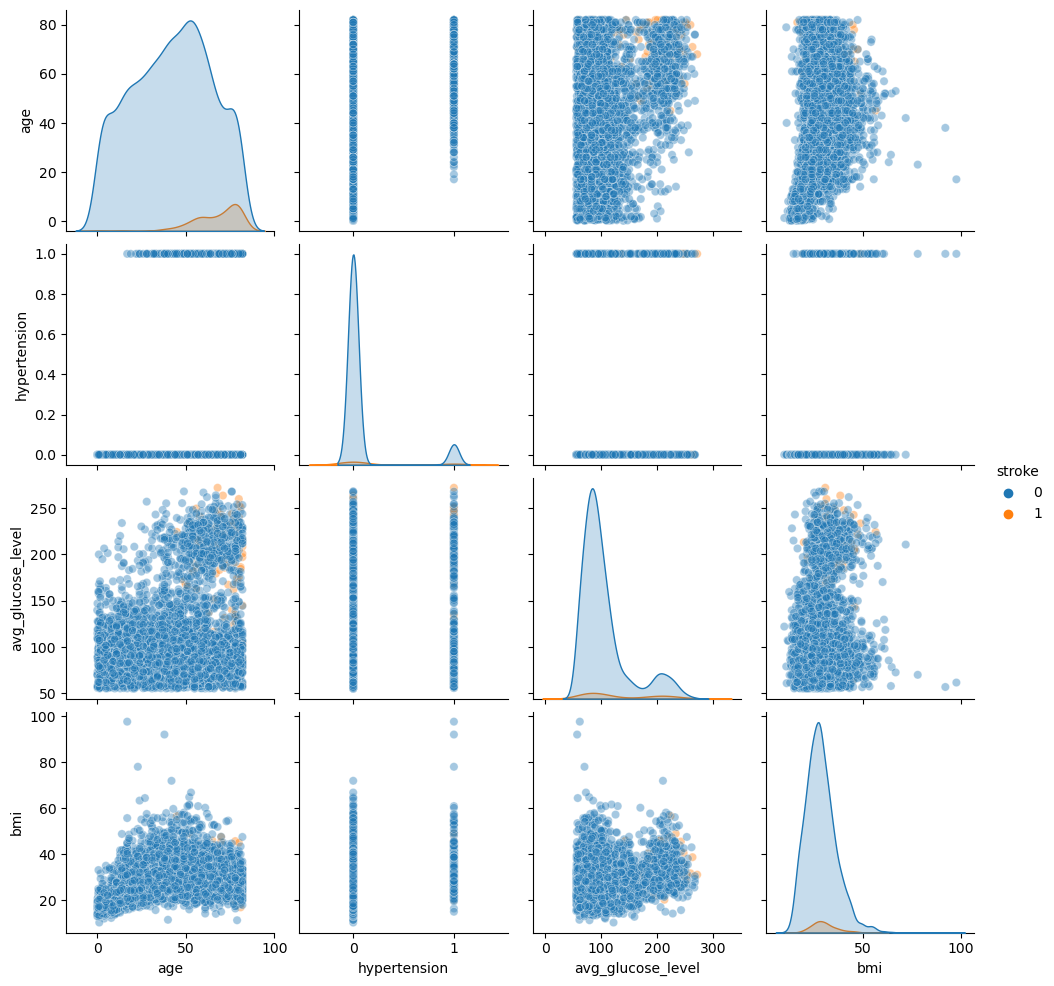

In [7]:
sns.pairplot(df[['age','hypertension','avg_glucose_level','bmi','stroke']], hue='stroke',
             plot_kws={'alpha':0.4})

# Preprocessing

In [8]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [9]:
#drop the one missing value in 'gender'
df = df[df['gender']!='Other']
df.reset_index(drop=True, inplace=True)

In [10]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

The unknown smaking status needs to be imputed.

In [11]:
df = df.replace({'smoking_status': {'Unknown': np.nan}})

## Splitting train/test data

In [12]:
#splitting data with stratify
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis=1), df.loc[:,'stroke'],
                                                    test_size = 0.2, random_state=42, 
                                                    stratify = df.loc[:,'stroke'])

In [13]:
y_test.value_counts()

0    972
1     50
Name: stroke, dtype: int64

## Preprocessing pipeline

In [37]:
#preprocessing pipeline for onehot encoding during CV
    
# first select the numerical and categorical columns
cat_cols = X_train.select_dtypes('object').columns.tolist()
cont_cols = X_train.select_dtypes('number').columns.tolist()


#build data processing pipeline
cat_pipeline = Pipeline([
            ('encode',OneHotEncoder(handle_unknown='ignore', sparse=False)),
            ('imputer',SimpleImputer())
])

cont_pipeline = Pipeline([ 
            ('scale',MinMaxScaler())
])


preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', cont_pipeline, cont_cols)
])


#knnimputer = KNNImputer(n_neighbors=1)

polynomial = PolynomialFeatures(degree=2)

# Defining the evaluation metric: Brier Skill Score

In [38]:
probabilities = [199/(3888+199) for _ in range(len(y_train))]
brier_ref = brier_score_loss(y_train, probabilities)
def brier_skill_score(y_true, y_predicted):
    # calculate the brier score
    bs = brier_score_loss(y_true, y_predicted)
    # calculate skill score
    return 1.0 - (bs / brier_ref)

BSS_scorer = make_scorer(brier_skill_score, greater_is_better=True, needs_proba=True)

In [39]:
brier_ref

0.046320160679433245

# Logistic Regression

## Base logistic regression

In [40]:
#Logistic Regression Base

lr = LogisticRegression(max_iter=500)

cv_pipe = Pipeline([
('preprocessor', preprocessor),
('lr', lr)])

In [41]:
cv_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['id', 'age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [42]:
skf = StratifiedKFold(n_splits=5)

scores = cross_validate(cv_pipe, X_train, y_train, cv=skf, scoring=(BSS_scorer), return_estimator=True)

#mean BSS of lr base
np.mean(scores['test_score'])

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1138, in fit
    X, y = self._validate_data(
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/utils/validation.py", line 899, in check_array
    _assert_all_finite(
  File "/home/josh_wang/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/utils/validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [20]:
scores['estimator'][0].predict_proba(X_test)[:,1]

array([0.01251098, 0.00193138, 0.04346984, ..., 0.01479099, 0.00643038,
       0.02115363])

In [559]:
#brier score on testing set
bs=brier_score_loss(y_test, scores['estimator'][0].predict_proba(X_test)[:,1])
1.0 - (bs / brier_ref)

0.06820342770380172

In [455]:
#get feature names after onehotencoding and polynomial
onehotencodeddf=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
polynomial = PolynomialFeatures(degree=2).fit(onehotencodeddf)
polynomial.get_feature_names_out()

In [438]:
#get coefficients
fitted_lr = scores['estimator'][0].named_steps
fitted_lr['lr'].coef_

## Tuned Logistic Regression

In [21]:
#Logistic Regression GridSearch

ratios=[]
for n in np.arange(1,6):
    # setup for the ratio argument of RandomOverSampler initialization
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratios.append({1 : n_pos * n, 0 : n_neg})

classweights=[]
for n in np.arange(1,11,3):
    classweights.append({1 : n, 0 : 1})

penalty=['l1', 'l2'] 
    
lr_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('imputer', knnimputer),
        #('poly', polynomial),
        #('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('lr', LogisticRegression(solver='liblinear'))
        ])

params = [{
         #'oversampling__sampling_strategy':ratios,
         #'oversampling__random_state':[42],
#         'undersampling__sampling_strategy':['majority'],
#         'undersampling__n_neighbors':np.arange(1,5),
        'lr__C': np.logspace(0.001, 4, 4),
        'lr__class_weight':classweights,
        'lr__penalty':penalty
        }]

skf = StratifiedKFold(n_splits=5)

gs_lr = GridSearchCV(lr_pipe,
                    param_grid=params,
                    scoring=BSS_scorer,
                    refit=True,
                    cv=skf,
                    n_jobs=-1,
                    error_score='raise',
                    verbose=4)

gs_lr.fit(X_train, y_train)
#y_pred_gs=gs_lr.predict(X_test)

print(gs_lr.best_params_)
print(gs_lr.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'lr__C': 1.0023052380778996, 'lr__class_weight': {1: 1, 0: 1}, 'lr__penalty': 'l1'}
0.07804219709185374


In [637]:
gs_lr.predict_proba(X_train)[:,1]

array([0.01902266, 0.00654649, 0.00821483, ..., 0.05110687, 0.00602704,
       0.01543456])

In [638]:
#brier score on testing set
bs=brier_score_loss(y_train, gs_lr.predict_proba(X_train)[:,1])
1.0 - (bs / brier_ref)

0.08776006100523959

## Plot important features

In [25]:
preprocessor2 = Pipeline([
        ('preprocessor', preprocessor),
        ('imputer', knnimputer)])
preprocessor2.fit(X_train).get_feature_names_out()

array(['cat__gender_Female', 'cat__gender_Male', 'cat__ever_married_No',
       'cat__ever_married_Yes', 'cat__work_type_Govt_job',
       'cat__work_type_Never_worked', 'cat__work_type_Private',
       'cat__work_type_Self-employed', 'cat__work_type_children',
       'cat__Residence_type_Rural', 'cat__Residence_type_Urban',
       'cat__smoking_status_formerly smoked',
       'cat__smoking_status_never smoked', 'cat__smoking_status_smokes',
       'cat__smoking_status_nan', 'num__id', 'num__age',
       'num__hypertension', 'num__heart_disease',
       'num__avg_glucose_level', 'num__bmi'], dtype=object)

In [26]:
#get coefficients
coef_dict=dict(zip(preprocessor.fit(X_train).get_feature_names_out(),gs_lr.best_estimator_['lr'].coef_[0]))
coef_df=pd.DataFrame(coef_dict.items(),columns=['Feature','Coefficient'])
coef_df=coef_df.sort_values('Coefficient',ascending=False)

In [27]:
coef_df.head()

,Feature,Coefficient
16,num__age,5.554773
19,num__avg_glucose_level,0.837744
17,num__hypertension,0.502636
15,num__id,0.172437
18,num__heart_disease,0.150128


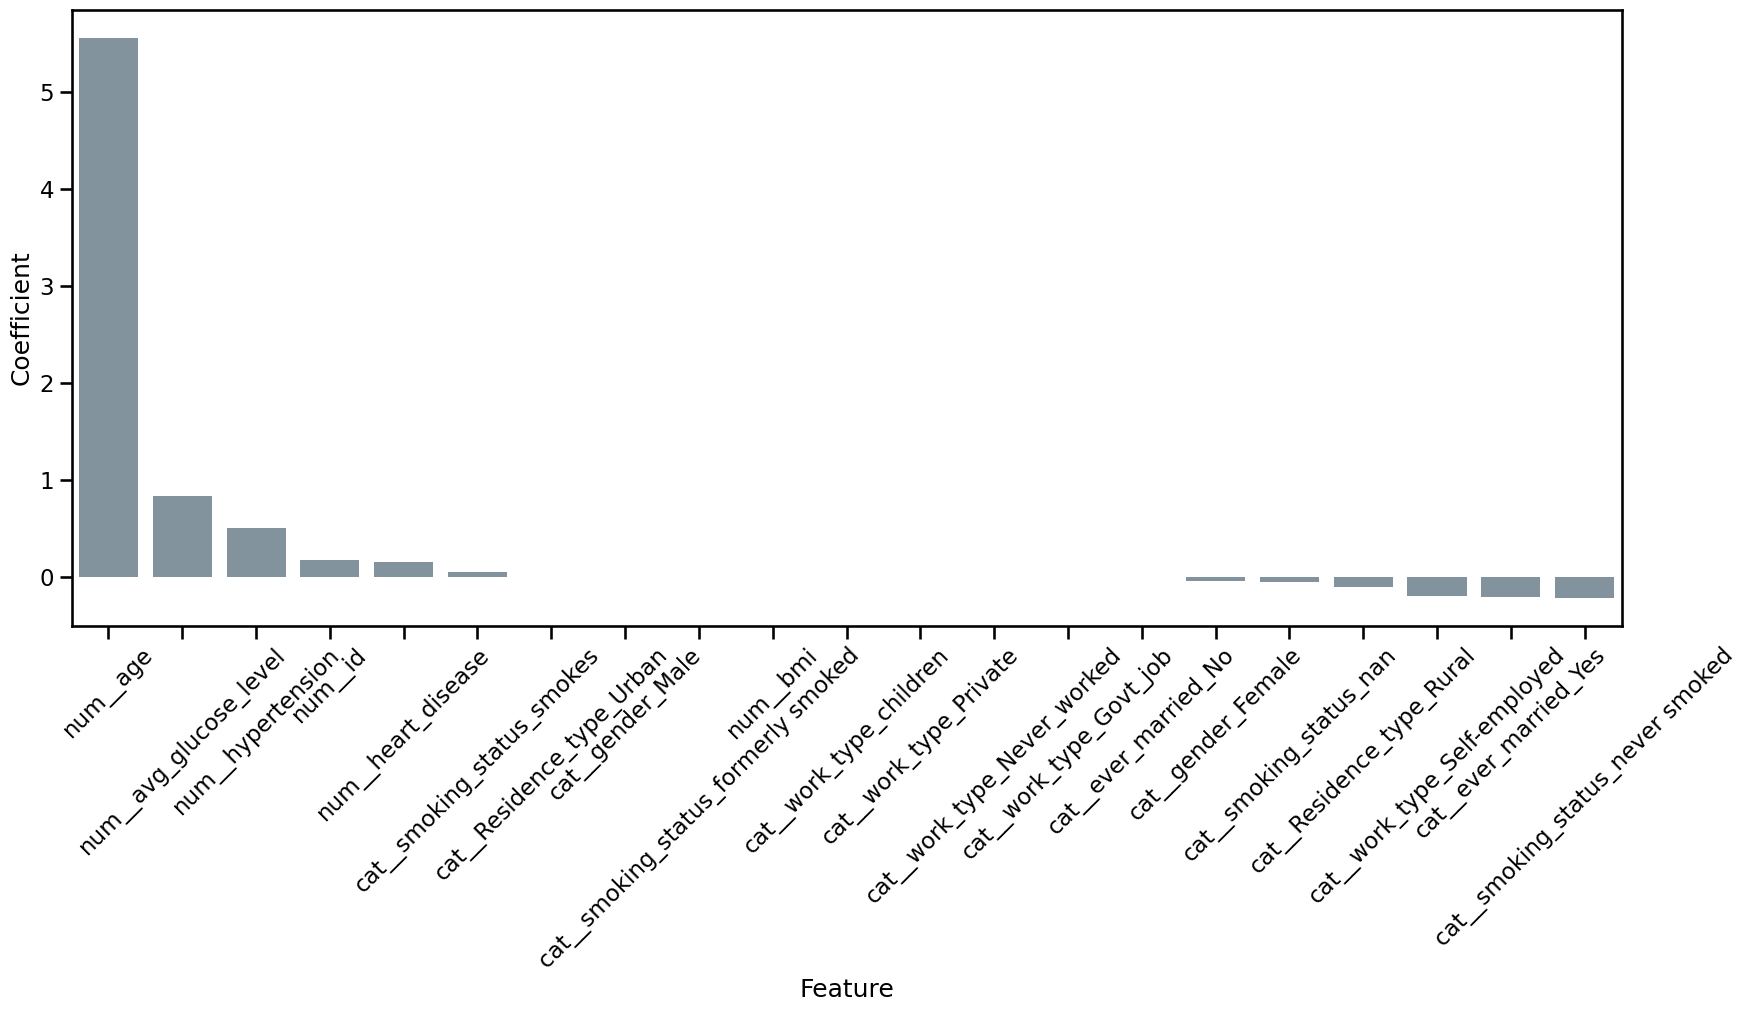

In [43]:
#coefficient plot
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(params) #changes text color

plt.figure(figsize = (20,8),facecolor='white')
sns.set_context("talk")
coplot=sns.barplot(x='Feature',y='Coefficient',data=coef_df, color='#7f94a1')
#coplot.set_xticklabels([])
plt.xticks(rotation=45)


#coplot.set_facecolor("white") #set color around plot to be white

coplot.figure.savefig("coef_plot.png",
                      bbox_inches="tight",
                      transparent=True
                     ); #avoid cutting off labels

plt.show()

# KNN

In [648]:
#KNN base
calibrated_knn = CalibratedClassifierCV(base_estimator=KNeighborsClassifier(), method='sigmoid') 

cv_pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('poly', polynomial),
        ('calibrated_knn', calibrated_knn)
        ])

scores = cross_validate(cv_pipe, X_train, y_train, cv=5, scoring=(BSS_scorer),return_estimator = True)

In [649]:
#mean BSS of KNN base
np.mean(scores['test_score'])

0.01267309849672904

In [631]:
#KNN GridSearchCV calibrated

calibrated_knn = CalibratedClassifierCV(base_estimator=KNeighborsClassifier())        

method=['sigmoid', 'isotonic']  

ratios=[]
for n in np.arange(1,8,2):
    # setup for the ratio argument of RandomOverSampler initialization
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratios.append({1 : n_pos * n, 0 : n_neg})

knn_pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('poly', polynomial),
        ('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_knn', calibrated_knn)
        ])

params = [{
        'oversampling__sampling_strategy':ratios,
        'oversampling__random_state':[42],
        #'undersampling__sampling_strategy':['majority'],
        #'undersampling__n_neighbors':np.arange(1,10),
        'calibrated_knn__base_estimator__n_neighbors': np.arange(50, 150, 5),
        'calibrated_knn__base_estimator__weights':['uniform', 'distance'],
        'calibrated_knn__method':method
          }]

gs_knn = RandomizedSearchCV(
                    knn_pipe,
                    param_distributions=params,
                    scoring=BSS_scorer,
                    refit=True,
                    n_iter=30,
                    random_state=42,
                    cv=5,
                    n_jobs=-1,
                    verbose=4
                    )

gs_knn.fit(X_train, y_train)
y_pred_gs=gs_knn.predict(X_test)

print(gs_knn.best_params_)
print(gs_knn.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'oversampling__sampling_strategy': {1: 199, 0: 3888}, 'oversampling__random_state': 42, 'calibrated_knn__method': 'sigmoid', 'calibrated_knn__base_estimator__weights': 'uniform', 'calibrated_knn__base_estimator__n_neighbors': 120}
0.04252368465489762


In [599]:
#brier score on testing set
bs=brier_score_loss(y_test, gs_knn.predict_proba(X_test)[:,1])
1.0 - (bs / brier_ref)

0.04803988436773832

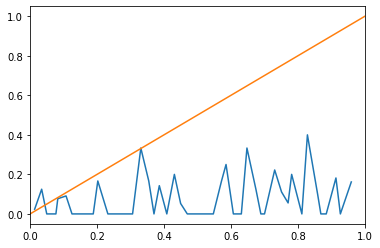

In [188]:
#Reliability Diagram
#https://towardsdatascience.com/how-to-enforce-the-outcome-of-your-ml-classifiers-b5f6163d68c2
from sklearn.calibration import calibration_curve

y_pred_gs_proba=gs_knn.predict_proba(X_test)
observed_pos_frequency, mean_pred_proba  = calibration_curve(y_test, y_pred_gs_proba[:,1], 
                                                             n_bins=50, strategy='uniform')
plt.plot(mean_pred_proba, observed_pos_frequency)
plt.plot([0, 1], [0, 1])
plt.xlim(0,1)
plt.show()

# RandomForest

In [646]:
#RandomForest base

calibrated_rf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=42))

cv_pipe = Pipeline([
('preprocessor', preprocessor),
#('poly', polynomial),
('calibrated_rf', calibrated_rf)])

scores = cross_validate(cv_pipe, X_train, y_train, cv=5, scoring=(BSS_scorer))

In [647]:
#mean BSS of RF base
np.mean(scores['test_score'])

0.03412472457676037

In [609]:
#RandomForest RandomSearchCV calibrated

classweights = []
for n in np.arange(1,11):
    classweights.append({1 : n, 0 : 1})    

max_features = [None, 'sqrt', 'log2']
    
n_estimators = np.logspace(1.5, 3.5, num=8, dtype = int)

# Maximum number of levels in tree
max_depth = np.linspace(10, 110, num = 5, dtype = int)
max_depth = np.append(max_depth, None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

calibrated_rf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=42))        

method=['sigmoid', 'isotonic']  

rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('poly', polynomial),
        #('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_rf', calibrated_rf)
        ])

params = [{
        #'oversampling__sampling_strategy':ratios,
        #'oversampling__random_state':[42],
        #'undersampling__sampling_strategy':['majority'],
        #'undersampling__n_neighbors':np.arange(1,7,2),
        'calibrated_rf__base_estimator__n_estimators': np.arange(30,150,3),
        'calibrated_rf__base_estimator__max_features': max_features,
        'calibrated_rf__base_estimator__max_depth': max_depth,
        'calibrated_rf__base_estimator__min_samples_split': min_samples_split,
        'calibrated_rf__base_estimator__min_samples_leaf': min_samples_leaf,
        'calibrated_rf__base_estimator__class_weight':classweights,
        'calibrated_rf__method':method
          }]

rd_rf = RandomizedSearchCV(rf_pipe,
                            param_distributions=params,
                            scoring=BSS_scorer,
                            refit=True,
                            cv=5,
                            n_iter=20,
                            n_jobs=-1,
                           random_state=42,
                          verbose=2)

rd_rf.fit(X_train, y_train)
y_pred_gs=rd_rf.predict(X_test)

print(rd_rf.best_params_)
print(rd_rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'calibrated_rf__method': 'isotonic', 'calibrated_rf__base_estimator__n_estimators': 63, 'calibrated_rf__base_estimator__min_samples_split': 10, 'calibrated_rf__base_estimator__min_samples_leaf': 1, 'calibrated_rf__base_estimator__max_features': 'sqrt', 'calibrated_rf__base_estimator__max_depth': 35, 'calibrated_rf__base_estimator__class_weight': {1: 2, 0: 1}}
0.07145140566932277


In [628]:
#RandomForest GridSearchCV calibrated

classweights = []
for n in np.arange(3,6):
    classweights.append({1 : n, 0 : 1})    

max_features = [None, 'sqrt', 'log2']
    
n_estimators = np.logspace(1.5, 3.5, num=8, dtype = int)

# Maximum number of levels in tree
max_depth = np.linspace(15, 50, num = 5, dtype = int)
max_depth = np.append(max_depth, None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

calibrated_rf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=42))        

method=['sigmoid', 'isotonic']  

rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('poly', polynomial),
        #('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_rf', calibrated_rf)
        ])

params = [{
        #'oversampling__sampling_strategy':ratios,
        #'oversampling__random_state':[42],
        #'undersampling__sampling_strategy':['majority'],
        #'undersampling__n_neighbors':np.arange(140,190,5),
        'calibrated_rf__base_estimator__n_estimators': np.arange(68,71,2),
        'calibrated_rf__base_estimator__max_features': ['sqrt'],
        'calibrated_rf__base_estimator__max_depth': np.arange(18,26,2),
        'calibrated_rf__base_estimator__min_samples_split': [11],
        'calibrated_rf__base_estimator__min_samples_leaf': [1],
        'calibrated_rf__base_estimator__class_weight':classweights,
        'calibrated_rf__method':['isotonic']
          }]

gs_rf = GridSearchCV(rf_pipe,
                            param_grid=params,
                            scoring=BSS_scorer,
                            refit=True,
                            cv=5,
                            n_jobs=-1,
                          verbose=4)

gs_rf.fit(X_train, y_train)
y_pred_gs=gs_rf.predict(X_test)

print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'calibrated_rf__base_estimator__class_weight': {1: 3, 0: 1}, 'calibrated_rf__base_estimator__max_depth': 18, 'calibrated_rf__base_estimator__max_features': 'sqrt', 'calibrated_rf__base_estimator__min_samples_leaf': 1, 'calibrated_rf__base_estimator__min_samples_split': 11, 'calibrated_rf__base_estimator__n_estimators': 68, 'calibrated_rf__method': 'isotonic'}
0.07616450575397413


In [627]:
np.arange(2,4)

array([2, 3])

# XGBoost

In [644]:
#XGBoost base

calibrated_xgb = CalibratedClassifierCV(base_estimator=XGBClassifier(random_state=42))

cv_pipe = Pipeline([
            ('preprocessor', preprocessor),
            #('poly', polynomial),
            ('calibrated_xgb', calibrated_xgb)
            ])

scores = cross_validate(cv_pipe, X_train, y_train, cv=5, scoring=(BSS_scorer))

In [645]:
#mean BSS of XGB base
np.mean(scores['test_score'])

0.020908023007475563

In [617]:
#XGB RandomSearchCV calibrated

# classweights = []
# for n in np.arange(1,11):
#     classweights.append({1 : n, 0 : 1})    

max_features = [None, 'sqrt', 'log2']
    
n_estimators = np.logspace(1.5, 3.5, num=8, dtype = int)

# Maximum number of levels in tree
max_depth = np.linspace(10, 110, num = 5, dtype = int)
max_depth = np.append(max_depth, None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

calibrated_xgb = CalibratedClassifierCV(base_estimator=XGBClassifier(random_state=42))        

method=['sigmoid', 'isotonic']  

xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('poly', polynomial),
        #('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_xgb', calibrated_xgb)
        ])

params = [{
        #'oversampling__sampling_strategy':ratios,
        #'oversampling__random_state':[42],
        #'undersampling__sampling_strategy':['majority'],
        #'undersampling__n_neighbors':np.arange(1,10),
        'calibrated_xgb__base_estimator__max_depth': [5,6,7],
        'calibrated_xgb__base_estimator__learning_rate': [0.1],
        'calibrated_xgb__base_estimator__gamma': [0],
        'calibrated_xgb__base_estimator__reg_lambda': [0],
        'calibrated_xgb__base_estimator__scale_pos_weight': [1, 3, 5],
        'calibrated_xgb__base_estimator__subsample': [0.9],
        'calibrated_xgb__base_estimator__colsample_bytree': [0.6, 0.65, 0.7],
        'calibrated_xgb__method':method
          }]

rd_xgb = RandomizedSearchCV(xgb_pipe,
                            param_distributions=params,
                            scoring=BSS_scorer,
                            refit=True,
                            cv=5,
                            n_iter=30,
                            n_jobs=-1,
                           random_state=42,
                          verbose=2)

rd_xgb.fit(X_train, y_train)
y_pred_gs=rd_xgb.predict(X_test)

print(rd_xgb.best_params_)
print(rd_xgb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'calibrated_xgb__method': 'isotonic', 'calibrated_xgb__base_estimator__subsample': 0.9, 'calibrated_xgb__base_estimator__scale_pos_weight': 1, 'calibrated_xgb__base_estimator__reg_lambda': 0, 'calibrated_xgb__base_estimator__max_depth': 6, 'calibrated_xgb__base_estimator__learning_rate': 0.1, 'calibrated_xgb__base_estimator__gamma': 0, 'calibrated_xgb__base_estimator__colsample_bytree': 0.65}
0.06113779800462045


In [623]:
#XGB GridSearchCV calibrated  

calibrated_xgb = CalibratedClassifierCV(base_estimator=XGBClassifier(random_state=42))        

method=['sigmoid', 'isotonic']  

xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('poly', polynomial),
        #('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_xgb', calibrated_xgb)
        ])

params = [{#'oversampling__sampling_strategy':ratios,
           #'oversampling__random_state':[42],
        #'undersampling__sampling_strategy':['majority'],
        #'undersampling__n_neighbors':[187],
        'calibrated_xgb__base_estimator__max_depth': [6],
        'calibrated_xgb__base_estimator__learning_rate': [0.005,0.01,0.015],
        'calibrated_xgb__base_estimator__gamma': [0.1],
        'calibrated_xgb__base_estimator__reg_lambda': [0],
        'calibrated_xgb__base_estimator__scale_pos_weight': [2],
        'calibrated_xgb__base_estimator__subsample': [0.9],
        'calibrated_xgb__base_estimator__colsample_bytree': [0.65],
        'calibrated_xgb__method':['isotonic'] 
          }]

gs_xgb = GridSearchCV(xgb_pipe,
                            param_grid=params,
                            scoring=BSS_scorer,
                            refit=True,
                            cv=5,
                            n_jobs=-1,
                          verbose=4)

gs_xgb.fit(X_train, y_train)
y_pred_gs=gs_xgb.predict(X_test)

print(gs_xgb.best_params_)
print(gs_xgb.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'calibrated_xgb__base_estimator__colsample_bytree': 0.65, 'calibrated_xgb__base_estimator__gamma': 0.1, 'calibrated_xgb__base_estimator__learning_rate': 0.005, 'calibrated_xgb__base_estimator__max_depth': 6, 'calibrated_xgb__base_estimator__reg_lambda': 0, 'calibrated_xgb__base_estimator__scale_pos_weight': 2, 'calibrated_xgb__base_estimator__subsample': 0.9, 'calibrated_xgb__method': 'isotonic'}
0.07512529472014359


# SVC

In [658]:
#SVC base

calibrated_svc = CalibratedClassifierCV(base_estimator=SVC())

cv_pipe = Pipeline([
('preprocessor', preprocessor),
#('poly', polynomial),
('calibrated_svc', calibrated_svc)])

scores = cross_validate(cv_pipe, X_train, y_train, cv=5, scoring=(BSS_scorer))

In [659]:
np.mean(scores['test_score'])

0.007114369470521043

In [662]:
#SVC RandomSearchCV calibrated

classweights = []
for n in np.arange(4,10,2):
    classweights.append({1 : n, 0 : 1})    

kernels = ['linear', 'rbf', 'poly']
    
gammas = [0.1, 1, 10, 100]

cs = [0.1, 1, 10, 100, 1000]

degrees = [2, 3, 4, 5, 6]

method=['sigmoid', 'isotonic']  

calibrated_svc = CalibratedClassifierCV(base_estimator=SVC(random_state=42))      

svc_pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('oversampling', over_sampling.SMOTE()),
         #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_svc', calibrated_svc)
        ])

params = [{
        #'oversampling__sampling_strategy':ratios,
        #'oversampling__random_state':[42],
        # 'undersampling__sampling_strategy':['majority'],
         #'undersampling__n_neighbors':np.arange(80,150),
        'calibrated_svc__base_estimator__kernel': ['rbf'],
        'calibrated_svc__base_estimator__C': [0.1, 1, 10, 20],
        'calibrated_svc__base_estimator__gamma': [0.01,,0.05,0.1],
        #'calibrated_svc__base_estimator__degree': degrees,
        'calibrated_svc__base_estimator__class_weight': classweights,
        'calibrated_svc__method':['isotonic'] 
          }]

rd_svc = RandomizedSearchCV(svc_pipe,
                            param_distributions=params,
                            scoring=BSS_scorer,
                            refit=True,
                            cv=5,
                            n_iter=30,
                            n_jobs=-1,
                           random_state=42,
                          verbose=3)

rd_svc.fit(X_train, y_train)
y_pred_gs=rd_svc.predict(X_test)

print(rd_svc.best_params_)
print(rd_svc.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'calibrated_svc__method': 'isotonic', 'calibrated_svc__base_estimator__kernel': 'rbf', 'calibrated_svc__base_estimator__gamma': 0.01, 'calibrated_svc__base_estimator__class_weight': {1: 5, 0: 1}, 'calibrated_svc__base_estimator__C': 10}
0.0692580903221428


In [671]:
#SVC GridSearchCV calibrated

classweights = []
for n in np.arange(9,13):
    classweights.append({1 : n, 0 : 1})    

kernels = ['linear', 'rbf', 'poly']
    
gammas = [0.1, 1, 10, 100]

cs = [0.1, 1, 10, 100, 1000]

degrees = [2, 3, 4, 5, 6]

calibrated_svc = CalibratedClassifierCV(base_estimator=SVC(random_state=42))      

svc_pipe = Pipeline([
        ('preprocessor', preprocessor),
        #('poly', polynomial),
        #('oversampling', over_sampling.SMOTE()),
        #('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_svc', calibrated_svc)
        ])

params = [{
        #'oversampling__sampling_strategy':ratios,
        #'oversampling__random_state':[42],
        # 'undersampling__sampling_strategy':['majority'],
         #'undersampling__n_neighbors':np.arange(80,150),
        'calibrated_svc__base_estimator__kernel': ['rbf'],
        'calibrated_svc__base_estimator__C': [0.4, 0.5],
        'calibrated_svc__base_estimator__gamma': [0.001,0.005,0.01],
        #'calibrated_svc__base_estimator__degree': degrees,
        'calibrated_svc__base_estimator__class_weight': classweights,
        'calibrated_svc__method':['isotonic'] 
          }]

gs_svc = GridSearchCV(svc_pipe,
                    param_grid=params,
                    scoring=BSS_scorer,
                    refit=True,
                    cv=5,
                    n_jobs=-1,
                    verbose=3)

gs_svc.fit(X_train, y_train)
y_pred_gs=gs_svc.predict(X_test)

print(gs_svc.best_params_)
print(gs_svc.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'calibrated_svc__base_estimator__C': 0.5, 'calibrated_svc__base_estimator__class_weight': {1: 9, 0: 1}, 'calibrated_svc__base_estimator__gamma': 0.01, 'calibrated_svc__base_estimator__kernel': 'rbf', 'calibrated_svc__method': 'isotonic'}
0.08319808610063259


In [669]:
#brier score on testing set
bs=brier_score_loss(y_test, gs_svc.predict_proba(X_test)[:,1])
1.0 - (bs / brier_ref)

0.11281787861391557

# Prepare for Streamlit

In [733]:
X_test_proba=gs_svc.predict_proba(X_test)[:,1]

In [683]:
import pickle
pickle.dump(gs_svc, open('stroke_gs_svc.pkl', 'wb'))

In [734]:

pickle.dump(X_test_proba, open('X_test_proba.pkl', 'wb'))

In [743]:
from scipy.stats import percentileofscore
percentile=percentileofscore(X_test_proba, 0.2)

In [751]:
prediction_proba=0.2

Text(0.30000000000000004, 400, '97.55% percentile')

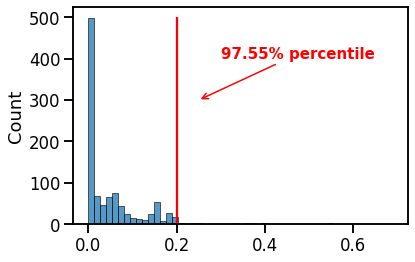

In [752]:
fig=sns.histplot(data=gs_svc.predict_proba(X_test)[:,1])
#plot where the patient proba lands
plt.vlines(0.2, 0, 500, color='r', label='', colors="r")
plt.annotate(str(round(percentile, 2))+'% percentile', xy=(prediction_proba+0.05, 300), weight='bold', color='r',
             xytext=(prediction_proba+0.1, 400), fontsize=15, arrowprops=dict(arrowstyle="->", color='r'))

<AxesSubplot:xlabel='stroke', ylabel='Count'>

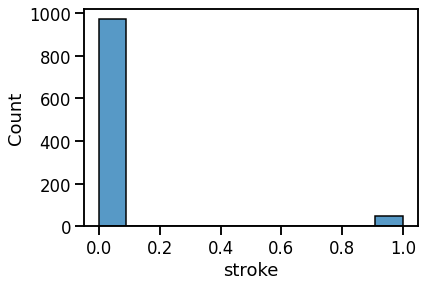

In [682]:
sns.histplot(y_test)